In [27]:
import pandas as pd
import pandas_ta as ta
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

1. 클래스 생성
2. 데이터에 기술적 지표 추가
3. normalization
4. xgboost 모델
5. 시각화

6. 된다면 랜덤포레스트 모델과 합치기 까지도?

In [126]:
class CryptoAnalysis:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = pd.read_csv(file_path, parse_dates=['open_time'], index_col='open_time')
        # 스펠링 은 조정
        if 'Adj Close' not in self.df.columns:
            self.df['Adj Close'] = self.df['close']  # 조정 종가 설정
        self.important_features = None
        self.model = None
        self.y_test = None
        self.y_pred = None
        self.X_test = None
        self.evals_result_ = None
        self.prev_columns = None
        # print(self.df.columns)

    def calculate_indicators(self, short_term=30, medium_term=60, long_term=120):
        """
        length를 1시간 후 예측이라면 60을 기준으로 설정
        단기, 장기를 *2, /2 이런 식으로
        사용할 지표:
        1. SMA, EMA, WMA, MACD
        2. RSI
        3. 볼린저밴드
        4. VWAP
        5. OBV
        6. CMF
        7. NVT RATIO
        8. MVRV RATIO
        9. ADX
        10. ATR
        11. A/D line
        12. Fibonacci Retracement
        13. Stochastic Oscillator
        """
        #SMA
        # self.df['SMA_short'] = self.df.ta.sma(close=self.df['Adj Close'], length=short_term)
        # self.df['SMA_med'] = self.df.ta.sma(close=self.df['Adj Close'], length=medium_term)
        # self.df['SMA_long'] = self.df.ta.sma(close=self.df['Adj Close'], length=long_term)

        #EMA
        # self.df['EMA_short'] = self.df.ta.ema(close=self.df['Adj Close'], length=short_term)
        # self.df['EMA_med'] = self.df.ta.ema(close=self.df['Adj Close'], length=medium_term)
        # self.df['EMA_long'] = self.df.ta.ema(close=self.df['Adj Close'], length=long_term)

        #WMA
        # self.df['WMA_short'] = self.df.ta.wma(close=self.df['Adj Close'], length=short_term)
        self.df['WMA_med'] = self.df.ta.wma(close=self.df['Adj Close'], length=medium_term)
        # self.df['WMA_long'] = self.df.ta.wma(close=self.df['Adj Close'], length=long_term)

        #MACD
        macd_df = self.df.ta.macd(close=self.df['close'], fast=short_term, slow=long_term, signal=short_term)
        self.df[['MACD', 'MACD_signal', 'MACD_hist']] = macd_df

        #RSI
        # self.df['RSI_short'] = ta.rsi(self.df['close'], length=short_term)
        self.df['RSI_med'] = ta.rsi(self.df['close'], length=medium_term)
        # self.df['RSI_long'] = ta.rsi(self.df['close'], length=long_term)

        #볼린저밴드, 표준편차를 바꿔야 하나?
        # bbands_short = ta.bbands(self.df['close'], length=short_term)
        # self.df[['BBL_short', 'BBM_short', 'BBU_short']] = bbands_short[[f'BBL_{short_term}_2.0', f'BBM_{short_term}_2.0', f'BBU_{short_term}_2.0']]
        bbands_med = ta.bbands(self.df['close'], length=medium_term)
        self.df[['BBL_med', 'BBM_med', 'BBU_med']] = bbands_med[[f'BBL_{medium_term}_2.0', f'BBM_{medium_term}_2.0', f'BBU_{medium_term}_2.0']]
        # bbands_long = ta.bbands(self.df['close'], length=long_term)
        # self.df[['BBL_long', 'BBM_long', 'BBU_long']] = bbands_long[[f'BBL_{long_term}_2.0', f'BBM_{long_term}_2.0', f'BBU_{long_term}_2.0']]
        
        #VWAP
        self.df['VWAP'] = self.df.ta.vwap(high=self.df['high'], low=self.df['low'], close=self.df['close'], volume=self.df['volume'])

        #OVB
        self.df['OBV'] = self.df.ta.obv(close=self.df['close'], volume=self.df['volume'])

        #CMF
        # self.df['CMF_short'] = self.df.ta.cmf(high=self.df['high'], low=self.df['low'], close=self.df['close'], volume=self.df['volume'], length=short_term)
        self.df['CMF_med'] = self.df.ta.cmf(high=self.df['high'], low=self.df['low'], close=self.df['close'], volume=self.df['volume'], length=medium_term)
        # self.df['CMF_long'] = self.df.ta.cmf(high=self.df['high'], low=self.df['low'], close=self.df['close'], volume=self.df['volume'], length=long_term)

        #NVT ratio, 일단 이거라는데 columns 확인하고 고치자
        self.df['NVT_Ratio'] = (self.df['close'] * self.df['volume']) / self.df['taker_buy_quote_asset_volume']

        #MVRV ratio, 이것도 마찬가지
        self.df['MVRV_Ratio'] = (self.df['close'] * self.df['volume']) / self.df['taker_buy_base_asset_volume']

        #ADX
        # adx_df = ta.adx(self.df['high'], self.df['low'], self.df['close'], length=short_term)
        # self.df[['ADX_short', 'DMP_short', 'DMN_short']] = adx_df[[f'ADX_{short_term}', f'DMP_{short_term}', f'DMN_{short_term}']]
        adx_df = ta.adx(self.df['high'], self.df['low'], self.df['close'], length=medium_term)
        self.df[['ADX_med', 'DMP_med', 'DMN_med']] = adx_df[[f'ADX_{medium_term}', f'DMP_{medium_term}', f'DMN_{medium_term}']]
        # adx_df = ta.adx(self.df['high'], self.df['low'], self.df['close'], length=long_term)
        # self.df[['ADX_long', 'DMP_long', 'DMN_long']] = adx_df[[f'ADX_{long_term}', f'DMP_{long_term}', f'DMN_{long_term}']]

        #ATR
        # self.df['ATR_short'] = self.df.ta.atr(high=self.df['high'], low=self.df['low'], close=self.df['close'], length=short_term)
        self.df['ATR_med'] = self.df.ta.atr(high=self.df['high'], low=self.df['low'], close=self.df['close'], length=medium_term)
        # self.df['ATR_long'] = self.df.ta.atr(high=self.df['high'], low=self.df['low'], close=self.df['close'], length=long_term)

        #A/D line
        self.df['ADline'] = self.df.ta.ad(high=self.df['high'], low=self.df['low'], close=self.df['close'], volume=self.df['volume'])

        #Fibonacci Retracement
        #이건 어떻게할지 좀더 고민해보자analysis.plot_loss()

        #Stochastic Oscillator, 이것도 조정이 필요하다
        # so_df = self.df.ta.stoch(high=self.df['high'], low=self.df['low'], close=self.df['close'], k=medium_term, d=short_term)
        # self.df[['SO_K_short', 'SO_D_short']] = so_df[[f'STOCHk_{medium_term}_{short_term}_3', f'STOCHd_{medium_term}_{short_term}_3']]
        so_df = self.df.ta.stoch(high=self.df['high'], low=self.df['low'], close=self.df['close'], k=long_term, d=short_term)
        self.df[['SO_K_short', 'SO_D_short']] = so_df[[f'STOCHk_{long_term}_{short_term}_3', f'STOCHd_{long_term}_{short_term}_3']]

        self.df.dropna(inplace=True)
        return self.df

    def generate_labels(self, future_minutes=60):
        """ 
        특정 기간 후 가격 변동을 기반으로 상승, 횡보, 하락 판단 후 라벨링
        0 : 하락, 1 : 횡보, 2 : 상승                          
        """
        self.df['Future_Close'] = self.df['Adj Close'].shift(-future_minutes)
        self.df['Price_Change'] = (self.df['Future_Close'] - self.df['Adj Close']) / self.df['Adj Close']
        self.df['Label'] = np.where(self.df['Price_Change'] > 0.004, 2,   # 5% 이상 상승 → 2
                   np.where(self.df['Price_Change'] < -0.003, 0,  # -5% 이상 하락 → 0
                            1))  # 그 외 (보합) → 1
        self.df.drop(columns=['close_time'], inplace=True, errors='ignore')
        self.df.dropna(inplace=True)
        return self.df

    def train_model(self, model_type='XGBoost', n_estimators=500, threshold=0.02):
        """XGBoost 또는 랜덤 포레스트 모델을 사용하여 예측 모델 학습"""
        exclude_cols = ['Label', 'Future_Close', 'Price_Change', 'high', 'open', 'close', 'low']
        features = [col for col in self.df.columns if col not in exclude_cols]
    
        X = self.df[features]
        y = self.df['Label'].astype(int)
        print(X)
        print("✅ 사용되는 Feature 목록:", features)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
        print("✅ 데이터 크기 확인")
        print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
        print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
    
        if model_type == 'XGBoost':
            model = XGBClassifier(
            learning_rate=0.1,
            max_depth=6,
            n_estimators=500,
            subsample=0.8,
            eval_metric='mlogloss'
        )
    
            eval_set = [(X_train, y_train), (X_test, y_test)]
            model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
            self.evals_result_ = model.evals_result()
        else:
            model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
            model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
    
        print("✅ 예측값 크기:", y_pred.shape)
        print("✅ predict_proba() 크기:", model.predict_proba(X_test).shape)
    
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = y_pred
    
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
        print("Precision:", precision_score(y_test, y_pred, average='weighted'))
        print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    
        return model

    # 일단 시각화 정도만 남은 것 같다
    def plot_adj_close(self, show_sma=True, show_ema=True, show_bbands=True):
        """Adj Close 가격 시각화"""
        plt.figure(figsize=(12, 6))
    
        # 기본 가격 그래프
        plt.plot(self.df.index, self.df['Adj Close'], label="Adj Close", color='black', linewidth=1.5)
    
        # 이동 평균 (SMA)
        if show_sma and 'SMA_short' in self.df.columns:
            plt.plot(self.df.index, self.df['SMA_short'], label="SMA Short", linestyle="dashed", color='blue')
        if show_sma and 'SMA_med' in self.df.columns:
            plt.plot(self.df.index, self.df['SMA_med'], label="SMA Medium", linestyle="dashed", color='green')
    
        # 이동 평균 (EMA)
        if show_ema and 'EMA_short' in self.df.columns:
            plt.plot(self.df.index, self.df['EMA_short'], label="EMA Short", linestyle="dotted", color='red')
        if show_ema and 'EMA_med' in self.df.columns:
            plt.plot(self.df.index, self.df['EMA_med'], label="EMA Medium", linestyle="dotted", color='purple')
    
        # 볼린저 밴드 (BB)
        if show_bbands and 'BBL_short' in self.df.columns:
            plt.fill_between(self.df.index, self.df['BBL_short'], self.df['BBU_short'], color='gray', alpha=0.2, label="Bollinger Bands")
    
        plt.legend()
        plt.title("Adjusted Close Price with Indicators")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.grid(True)
        plt.show()

    def plot_adj_close_with_predictions(self, show_sma=True, show_ema=True, show_bbands=True):
        """Adj Close 가격 시각화 + 예측된 상승(빨간색), 하락(파란색)"""
        if not hasattr(self, 'y_pred') or self.y_pred is None:
            print("⚠ 모델이 학습되지 않았습니다. 먼저 `train_model()`을 실행하세요.")
            return
    
        plt.figure(figsize=(12, 6))
    
        # 상승(2), 횡보(1), 하락(0)에 따라 색상 지정
        colors = np.where(self.y_pred == 2, 'red',  # 상승(빨간색)
                          np.where(self.y_pred == 0, 'blue', 'gray'))  # 하락(파란색), 횡보(회색)
    
        # Adj Close 플롯 (색상 적용)
        for i in range(len(self.y_test) - 1):
            plt.plot(self.X_test.index[i:i+2], self.df.loc[self.X_test.index[i:i+2], 'Adj Close'],
                     color=colors[i], linewidth=1.5)
    
        # 이동 평균 (SMA)
        if show_sma and 'SMA_short' in self.df.columns:
            plt.plot(self.df.index, self.df['SMA_short'], label="SMA Short", linestyle="dashed", color='blue', alpha=0.5)
        if show_sma and 'SMA_med' in self.df.columns:
            plt.plot(self.df.index, self.df['SMA_med'], label="SMA Medium", linestyle="dashed", color='green', alpha=0.5)
    
        # 이동 평균 (EMA)
        if show_ema and 'EMA_short' in self.df.columns:
            plt.plot(self.df.index, self.df['EMA_short'], label="EMA Short", linestyle="dotted", color='red', alpha=0.5)
        if show_ema and 'EMA_med' in self.df.columns:
            plt.plot(self.df.index, self.df['EMA_med'], label="EMA Medium", linestyle="dotted", color='purple', alpha=0.5)
    
        # 볼린저 밴드 (BB)
        if show_bbands and 'BBL_short' in self.df.columns:
            plt.fill_between(self.df.index, self.df['BBL_short'], self.df['BBU_short'], color='gray', alpha=0.2, label="Bollinger Bands")
    
        plt.legend()
        plt.title("Adjusted Close Price with Predictions (Red: Up, Blue: Down, Gray: Neutral)")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.grid(True)
        plt.show()
        
    def plot_feature_importance(self):
        """모델에서 중요하게 선택된 Feature Importance 시각화"""
        if self.model is None:
            print("Model has not been trained yet.")
            return

        feature_importances = self.model.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]
        sorted_features = np.array(self.df.columns[:-2])[sorted_indices]  # 제외할 컬럼 고려
        sorted_importances = feature_importances[sorted_indices]

        plt.figure(figsize=(10, 6))
        plt.barh(sorted_features[:10], sorted_importances[:10], color='blue', alpha=0.7)
        plt.xlabel("Feature Importance Score")
        plt.ylabel("Features")
        plt.title("Top 10 Important Features")
        plt.gca().invert_yaxis()  # 가장 중요한 피처를 위로
        plt.show()

    def plot_prediction_distribution(self):
        """실제 라벨 vs. 예측된 라벨 분포 비교"""
        plt.figure(figsize=(10, 5))
        sns.histplot(self.y_test, color="blue", label="Actual", kde=True, bins=3)
        sns.histplot(self.y_pred, color="red", label="Predicted", kde=True, bins=3, alpha=0.5)
        plt.legend()
        plt.title("Actual vs Predicted Label Distribution")
        plt.xlabel("Label (0: 하락, 1: 횡보, 2: 상승)")
        plt.show()

    def plot_loss(self):
        """XGBoost 학습 과정의 Loss (logloss) 시각화"""
        if not hasattr(self, 'evals_result_') or self.evals_result_ is None:
            print("⚠ 손실 기록이 없습니다. 먼저 `train_model()`을 실행하세요.")
            return
    
        # 학습 손실 & 검증 손실 가져오기
        results = self.evals_result_
        train_loss = results['validation_0']['mlogloss']
        test_loss = results['validation_1']['mlogloss']
    
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss, label="Train Loss", color='blue', linestyle="dashed", marker="o")
        plt.plot(test_loss, label="Test Loss", color='red', linestyle="solid", marker="x")
    
        plt.xlabel("Epochs")
        plt.ylabel("Log Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_model(self, file_name="crypto_model.pkl"):
        """ 학습된 모델을 저장 """
        with open(file_name, 'wb') as f:
            pickle.dump(self.model, f)
        print(f"✅ 모델이 {file_name}에 저장되었습니다.")

    def load_model(self, file_name="crypto_model.pkl"):
        """ 저장된 모델을 불러오기 """
        with open(file_name, 'rb') as f:
            self.model = pickle.load(f)
        print(f"✅ {file_name}에서 모델을 불러왔습니다.")


In [127]:
file_path = "recent_week.csv"  # 사용자의 실제 데이터 파일명을 입력하세요.

# CryptoAnalysis 클래스 인스턴스 생성
analysis = CryptoAnalysis(file_path)

In [128]:
# 기술적 지표 계산
analysis.calculate_indicators()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,CMF_med,NVT_Ratio,MVRV_Ratio,ADX_med,DMP_med,DMN_med,ATR_med,ADline,SO_K_short,SO_D_short
open_time,,,,,,,,,,,,,,,,,,,,,
2025-03-09 09:38:00,85783.47,85792.72,85782.00,85792.72,1.85422,2025-03-09 09:38:59.999,1.590602e+05,785,1.14784,98464.715418,...,-0.173475,1.615590,1.385895e+05,11.014818,26.137666,34.645785,28.679697,-40.246981,29.692432,28.498235
2025-03-09 09:39:00,85792.72,85800.00,85773.95,85800.00,6.98404,2025-03-09 09:39:59.999,5.991376e+05,711,1.27081,109023.969698,...,-0.140833,5.496320,4.715344e+05,11.093357,25.707311,34.584146,28.632108,-33.262941,28.642845,29.050686
2025-03-09 09:40:00,85800.00,85808.00,85799.99,85808.00,1.00379,2025-03-09 09:40:59.999,8.612739e+04,670,0.67282,57728.911858,...,-0.109538,1.492029,1.280182e+05,11.149432,26.087211,34.407000,28.259444,-32.259151,30.549984,29.443533
2025-03-09 09:41:00,85807.99,85814.00,85805.03,85805.03,1.99790,2025-03-09 09:41:59.999,1.714393e+05,938,0.78712,67541.328804,...,-0.094305,2.538148,2.177938e+05,11.188781,26.323842,34.207458,27.911351,-34.257051,31.507052,29.746402
2025-03-09 09:42:00,85805.04,85806.75,85801.00,85801.01,1.81847,2025-03-09 09:42:59.999,1.560319e+05,435,1.08448,93051.416308,...,-0.107664,1.676778,1.438722e+05,11.235062,26.224697,34.342594,27.511984,-36.069195,31.585576,29.991370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-16 07:03:00,84228.00,84228.01,84224.40,84224.41,0.96145,2025-03-16 07:03:59.999,8.097936e+04,318,0.43304,36473.544732,...,-0.247679,2.220172,1.869979e+05,8.285863,28.868882,39.432289,13.420541,-3458.725340,0.003591,9.790267
2025-03-16 07:04:00,84224.41,84224.41,84224.40,84224.40,0.95044,2025-03-16 07:04:59.999,8.005024e+04,152,0.14730,12406.255593,...,-0.245639,6.452409,5.434504e+05,8.405530,28.868518,39.431791,13.197032,-3459.675780,0.003591,8.049310
2025-03-16 07:05:00,84224.41,84224.41,84224.40,84224.41,0.75182,2025-03-16 07:05:59.999,6.332159e+04,137,0.07342,6183.756182,...,-0.231347,10.239989,8.624570e+05,8.523203,28.868147,39.431284,12.977248,-3458.923960,0.003574,6.706723


In [129]:
# 미래 가격 변화에 따른 라벨 생성
analysis.generate_labels()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,...,ADX_med,DMP_med,DMN_med,ATR_med,ADline,SO_K_short,SO_D_short,Future_Close,Price_Change,Label
open_time,,,,,,,,,,,,,,,,,,,,,
2025-03-09 09:38:00,85783.47,85792.72,85782.00,85792.72,1.85422,159060.187262,785,1.14784,98464.715418,0,...,11.014818,26.137666,34.645785,28.679697,-40.246981,29.692432,28.498235,85089.39,-0.008198,0
2025-03-09 09:39:00,85792.72,85800.00,85773.95,85800.00,6.98404,599137.630010,711,1.27081,109023.969698,0,...,11.093357,25.707311,34.584146,28.632108,-33.262941,28.642845,29.050686,85118.67,-0.007941,0
2025-03-09 09:40:00,85800.00,85808.00,85799.99,85808.00,1.00379,86127.391588,670,0.67282,57728.911858,0,...,11.149432,26.087211,34.407000,28.259444,-32.259151,30.549984,29.443533,85174.00,-0.007389,0
2025-03-09 09:41:00,85807.99,85814.00,85805.03,85805.03,1.99790,171439.333114,938,0.78712,67541.328804,0,...,11.188781,26.323842,34.207458,27.911351,-34.257051,31.507052,29.746402,85183.56,-0.007243,0
2025-03-09 09:42:00,85805.04,85806.75,85801.00,85801.01,1.81847,156031.877247,435,1.08448,93051.416308,0,...,11.235062,26.224697,34.342594,27.511984,-36.069195,31.585576,29.991370,85119.40,-0.007944,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-16 06:03:00,84380.00,84380.01,84380.00,84380.01,0.92862,78356.957634,164,0.20340,17162.894034,0,...,8.544449,36.621233,30.880337,16.791971,-3424.136779,80.641786,71.099684,84224.41,-0.001844,1
2025-03-16 06:04:00,84380.01,84380.01,84370.72,84370.73,1.33182,112378.745824,287,0.15855,13378.431098,0,...,8.519037,36.281027,31.521448,16.666939,-3425.465731,76.115180,70.629343,84224.40,-0.001734,1
2025-03-16 06:05:00,84370.73,84370.73,84362.68,84362.68,1.38520,116864.139888,454,0.47679,40224.321502,0,...,8.472797,35.986431,32.076474,16.523323,-3426.850931,72.758982,70.059429,84224.41,-0.001639,1


In [130]:
print("현재 DataFrame 컬럼 목록:", list(analysis.df.columns))

현재 DataFrame 컬럼 목록: ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore', 'Adj Close', 'WMA_med', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI_med', 'BBL_med', 'BBM_med', 'BBU_med', 'VWAP', 'OBV', 'CMF_med', 'NVT_Ratio', 'MVRV_Ratio', 'ADX_med', 'DMP_med', 'DMN_med', 'ATR_med', 'ADline', 'SO_K_short', 'SO_D_short', 'Future_Close', 'Price_Change', 'Label']


In [131]:
# 모델 학습 (XGBoost 사용)
analysis.train_model(model_type='XGBoost')

                      volume  quote_asset_volume  number_of_trades  \
open_time                                                            
2025-03-09 09:38:00  1.85422       159060.187262               785   
2025-03-09 09:39:00  6.98404       599137.630010               711   
2025-03-09 09:40:00  1.00379        86127.391588               670   
2025-03-09 09:41:00  1.99790       171439.333114               938   
2025-03-09 09:42:00  1.81847       156031.877247               435   
...                      ...                 ...               ...   
2025-03-16 06:03:00  0.92862        78356.957634               164   
2025-03-16 06:04:00  1.33182       112378.745824               287   
2025-03-16 06:05:00  1.38520       116864.139888               454   
2025-03-16 06:06:00  1.78721       150751.171428               526   
2025-03-16 06:07:00  0.11258         9495.214871               101   

                     taker_buy_base_asset_volume  \
open_time                            

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

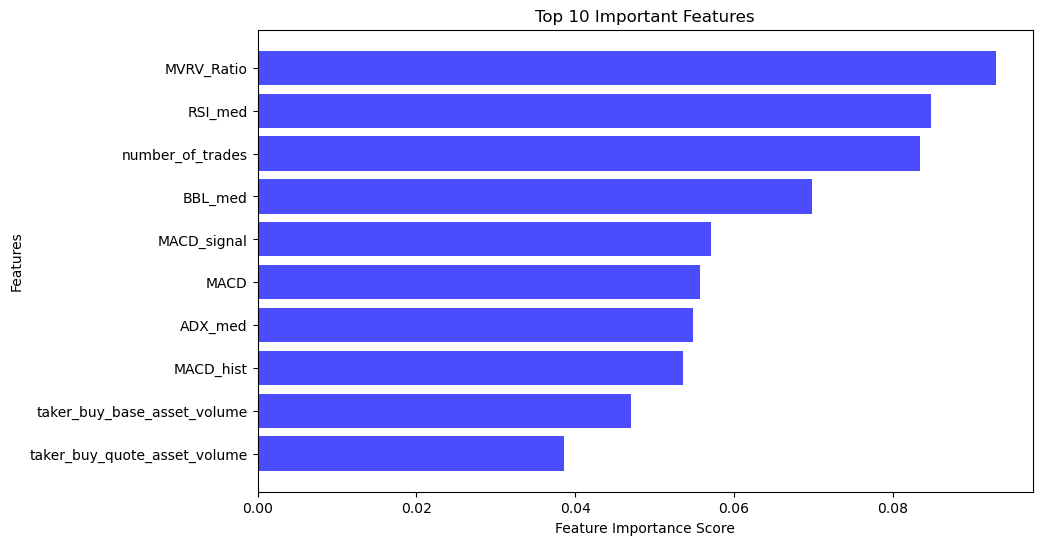

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46973 (\N{HANGUL SYLLABLE RAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54945 (\N{HANGUL SYLLABLE HOENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\s

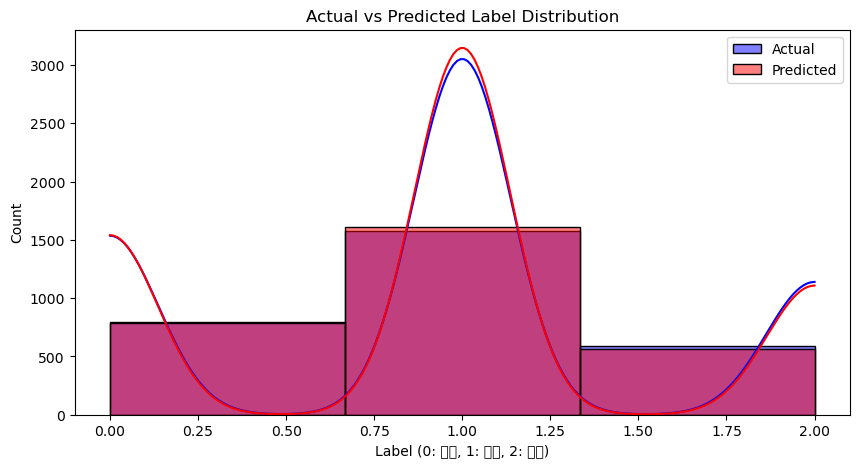

In [132]:
# 예측 결과 시각화 실행
analysis.plot_feature_importance()  # 실제 vs 예측된 값의 분포 비교
analysis.plot_prediction_distribution()

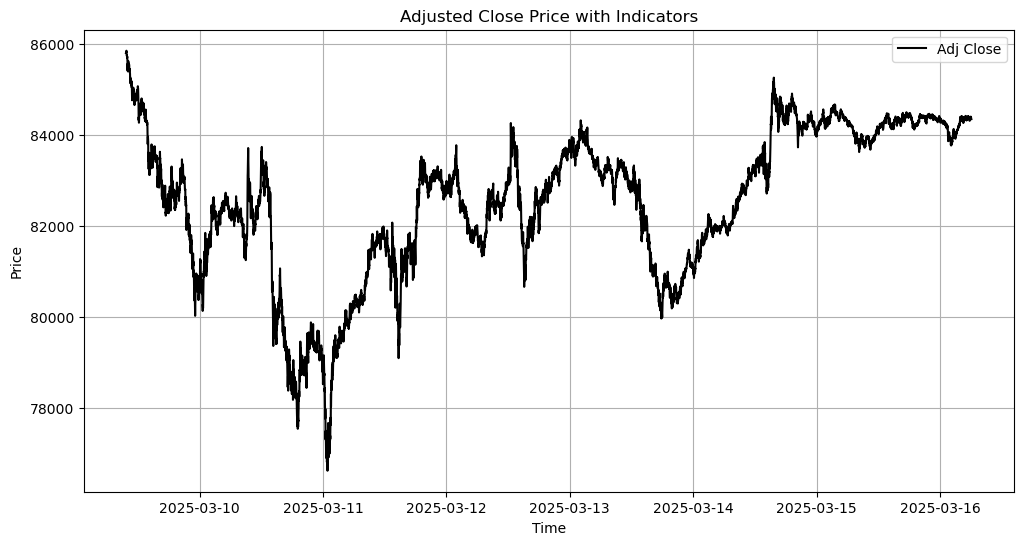

In [133]:
analysis.plot_adj_close()

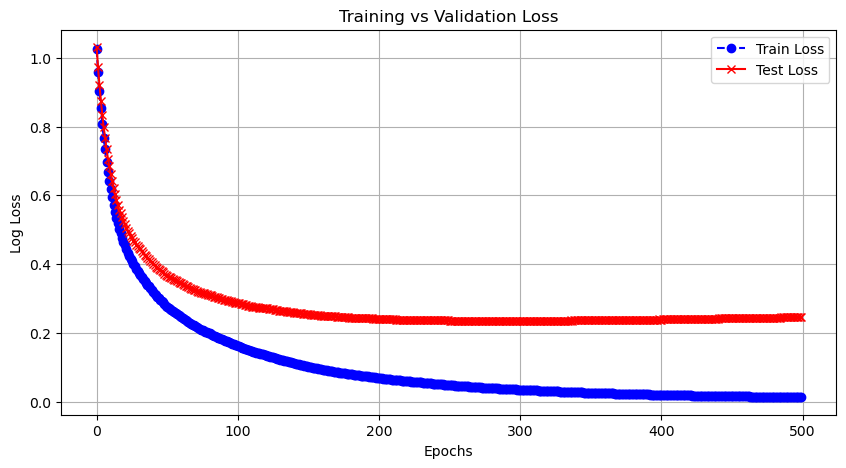

In [134]:
analysis.plot_loss()

In [135]:
analysis.save_model()

✅ 모델이 crypto_model.pkl에 저장되었습니다.


30분 뒤 예측으로 바꿔보자

In [136]:
file_path = "recent_week.csv"  # 사용자의 실제 데이터 파일명을 입력하세요.

# CryptoAnalysis 클래스 인스턴스 생성
analysis_30 = CryptoAnalysis(file_path)

In [137]:
analysis_30.calculate_indicators(short_term=15, medium_term=30, long_term=60)

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,CMF_med,NVT_Ratio,MVRV_Ratio,ADX_med,DMP_med,DMN_med,ATR_med,ADline,SO_K_short,SO_D_short
open_time,,,,,,,,,,,,,,,,,,,,,
2025-03-09 08:23:00,86010.75,86010.75,85955.17,85955.17,3.03773,2025-03-09 08:23:59.999,2.611789e+05,1395,0.11907,10236.999938,...,0.116037,25.506359,2.192900e+06,7.814191,30.029032,30.904320,28.614540,33.155793,32.251380,18.675132
2025-03-09 08:24:00,85955.17,85955.18,85932.19,85937.40,3.18252,2025-03-09 08:24:59.999,2.735296e+05,932,1.04433,89758.789524,...,0.133687,3.047027,2.618880e+05,7.741214,29.152417,32.920109,28.411626,31.415720,25.876382,18.736807
2025-03-09 08:25:00,85937.40,85941.34,85922.48,85930.94,1.23367,2025-03-09 08:25:59.999,1.060121e+05,816,0.33249,28571.814688,...,0.144955,3.710315,3.188379e+05,7.750333,28.447659,33.368905,28.067979,31.288821,15.410945,18.440447
2025-03-09 08:26:00,85930.93,85940.72,85930.93,85940.71,1.78964,2025-03-09 08:26:59.999,1.537868e+05,369,1.53355,131780.665503,...,0.128175,1.167113,1.002921e+05,7.759004,28.083094,32.941273,27.412111,33.074804,13.514577,18.270006
2025-03-09 08:27:00,85940.72,85947.04,85927.29,85927.29,3.28683,2025-03-09 08:27:59.999,2.824747e+05,924,1.61262,138598.536724,...,0.063344,2.037744,1.751364e+05,7.706290,28.185121,32.083221,27.137871,29.787974,12.188693,18.234855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-16 07:03:00,84228.00,84228.01,84224.40,84224.41,0.96145,2025-03-16 07:03:59.999,8.097936e+04,318,0.43304,36473.544732,...,-0.323197,2.220172,1.869979e+05,17.636971,22.614058,43.943256,11.134591,-3458.725340,0.004032,2.385390
2025-03-16 07:04:00,84224.41,84224.41,84224.40,84224.40,0.95044,2025-03-16 07:04:59.999,8.005024e+04,152,0.14730,12406.255593,...,-0.227486,6.452409,5.434504e+05,18.117284,22.613358,43.941895,10.763771,-3459.675780,0.004032,2.269753
2025-03-16 07:05:00,84224.41,84224.41,84224.40,84224.41,0.75182,2025-03-16 07:05:59.999,6.332159e+04,137,0.07342,6183.756182,...,-0.283208,10.239989,8.624570e+05,18.581586,22.612634,43.940488,10.405312,-3458.923960,0.003988,1.944760


In [138]:
# 미래 가격 변화에 따른 라벨 생성
analysis_30.generate_labels(future_minutes=30)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,...,ADX_med,DMP_med,DMN_med,ATR_med,ADline,SO_K_short,SO_D_short,Future_Close,Price_Change,Label
open_time,,,,,,,,,,,,,,,,,,,,,
2025-03-09 08:23:00,86010.75,86010.75,85955.17,85955.17,3.03773,261178.908853,1395,0.11907,10236.999938,0,...,7.814191,30.029032,30.904320,28.614540,33.155793,32.251380,18.675132,85862.02,-0.001084,1
2025-03-09 08:24:00,85955.17,85955.18,85932.19,85937.40,3.18252,273529.644965,932,1.04433,89758.789524,0,...,7.741214,29.152417,32.920109,28.411626,31.415720,25.876382,18.736807,85872.00,-0.000761,1
2025-03-09 08:25:00,85937.40,85941.34,85922.48,85930.94,1.23367,106012.091330,816,0.33249,28571.814688,0,...,7.750333,28.447659,33.368905,28.067979,31.288821,15.410945,18.440447,85857.90,-0.000850,1
2025-03-09 08:26:00,85930.93,85940.72,85930.93,85940.71,1.78964,153786.772232,369,1.53355,131780.665503,0,...,7.759004,28.083094,32.941273,27.412111,33.074804,13.514577,18.270006,85842.01,-0.001148,1
2025-03-09 08:27:00,85940.72,85947.04,85927.29,85927.29,3.28683,282474.652472,924,1.61262,138598.536724,0,...,7.706290,28.185121,32.083221,27.137871,29.787974,12.188693,18.234855,85837.00,-0.001051,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-16 06:33:00,84356.43,84365.47,84356.43,84365.46,0.71093,59972.598429,326,0.42229,35623.628381,0,...,6.888258,38.903190,35.708060,13.707911,-3436.413207,53.099516,33.346233,84224.41,-0.001672,1
2025-03-16 06:34:00,84365.46,84365.47,84298.66,84298.93,9.60416,809995.282725,1101,1.32061,111408.351376,0,...,7.082577,33.305728,43.011650,15.477981,-3445.939740,39.075165,33.214098,84224.40,-0.000884,1
2025-03-16 06:35:00,84298.93,84312.26,84298.93,84312.25,3.37779,284757.756535,583,3.14327,264985.878279,0,...,7.270419,32.345162,41.771157,15.406382,-3442.567018,25.650529,32.496241,84224.41,-0.001042,1


In [139]:
# 모델 학습 (XGBoost 사용)
analysis_30.train_model(model_type='XGBoost')

                      volume  quote_asset_volume  number_of_trades  \
open_time                                                            
2025-03-09 08:23:00  3.03773       261178.908853              1395   
2025-03-09 08:24:00  3.18252       273529.644965               932   
2025-03-09 08:25:00  1.23367       106012.091330               816   
2025-03-09 08:26:00  1.78964       153786.772232               369   
2025-03-09 08:27:00  3.28683       282474.652472               924   
...                      ...                 ...               ...   
2025-03-16 06:33:00  0.71093        59972.598429               326   
2025-03-16 06:34:00  9.60416       809995.282725              1101   
2025-03-16 06:35:00  3.37779       284757.756535               583   
2025-03-16 06:36:00  0.97881        82525.271909               280   
2025-03-16 06:37:00  2.84588       239942.546836               222   

                     taker_buy_base_asset_volume  \
open_time                            

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

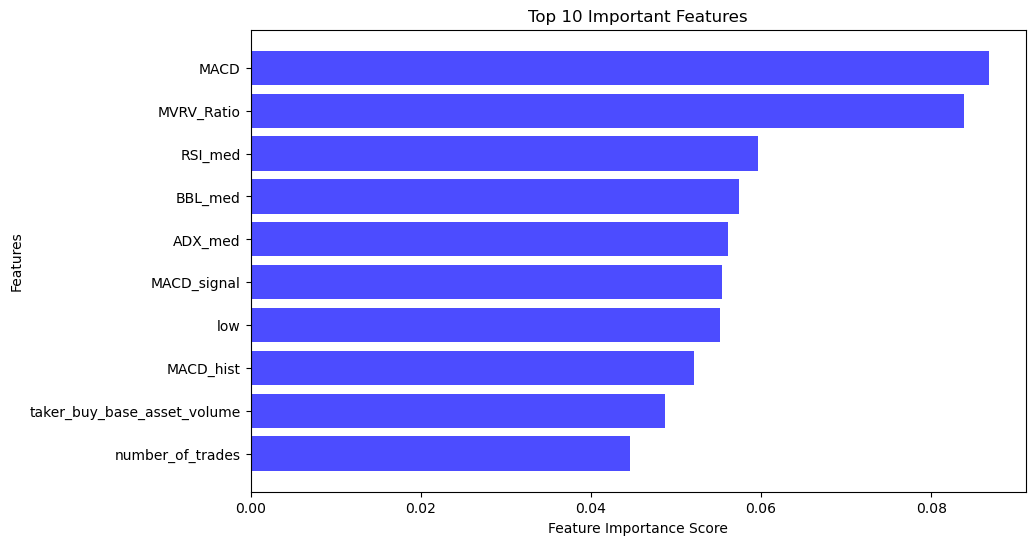

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46973 (\N{HANGUL SYLLABLE RAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54945 (\N{HANGUL SYLLABLE HOENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\s

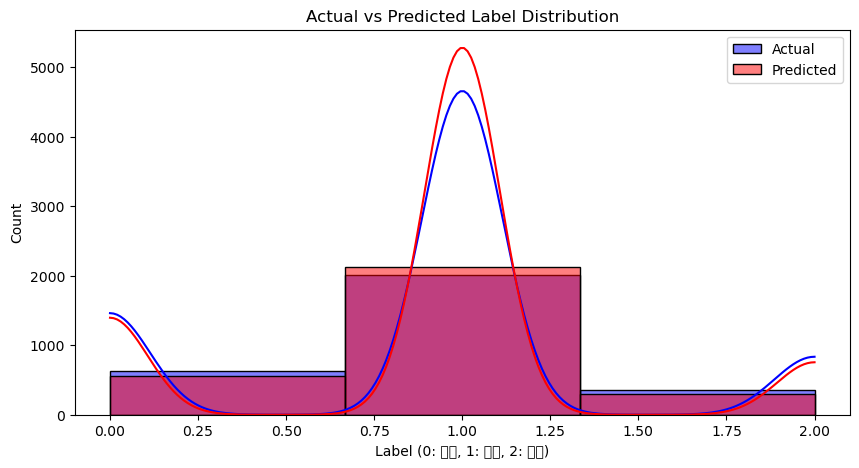

In [140]:
# 예측 결과 시각화 실행
analysis_30.plot_feature_importance()  # 실제 vs 예측된 값의 분포 비교
analysis_30.plot_prediction_distribution()

In [141]:
analysis_30.save_model(file_name="crypto_model_30.pkl")

✅ 모델이 crypto_model_30.pkl에 저장되었습니다.


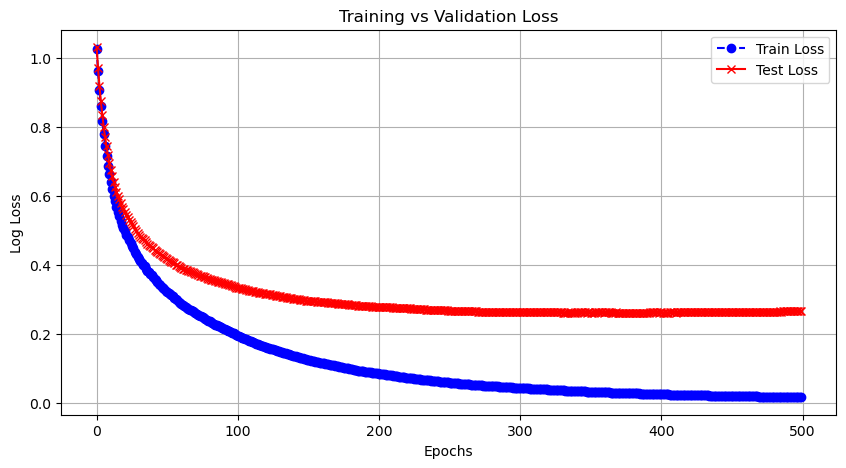

In [142]:
analysis_30.plot_loss()

In [143]:
file_path = "recent_week.csv"  # 사용자의 실제 데이터 파일명을 입력하세요.

# CryptoAnalysis 클래스 인스턴스 생성
analysis_15 = CryptoAnalysis(file_path)

In [144]:
analysis_15.calculate_indicators(short_term=7, medium_term=14, long_term=30)

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,CMF_med,NVT_Ratio,MVRV_Ratio,ADX_med,DMP_med,DMN_med,ATR_med,ADline,SO_K_short,SO_D_short
open_time,,,,,,,,,,,,,,,,,,,,,
2025-03-09 07:45:00,86011.35,86011.35,85980.08,85980.08,2.44164,2025-03-09 07:45:59.999,2.099734e+05,941,0.56843,48885.295410,...,-0.326460,4.294388,3.693197e+05,17.318647,27.038464,39.344943,28.220122,22.809318,28.267566,25.620817
2025-03-09 07:46:00,85980.07,85980.08,85944.87,85944.88,2.97467,2025-03-09 07:46:59.999,2.557116e+05,773,0.72497,62323.360859,...,-0.319231,4.102116,3.526458e+05,18.345672,24.522746,44.988423,28.751176,19.836337,18.029757,23.769478
2025-03-09 07:47:00,85944.88,85961.66,85924.00,85925.17,5.87127,2025-03-09 07:47:59.999,5.045798e+05,1358,1.75437,150778.920205,...,-0.336406,3.345891,2.875618e+05,19.737697,22.149006,45.997872,29.424959,14.329878,7.169798,20.726907
2025-03-09 07:48:00,85925.17,85960.00,85925.17,85960.00,5.27748,2025-03-09 07:48:59.999,4.535695e+05,1186,3.93404,338110.521739,...,-0.308148,1.341727,1.153146e+05,20.998003,20.201390,41.953168,29.832037,19.607358,6.126737,18.506323
2025-03-09 07:49:00,85959.99,85960.00,85959.99,85960.00,1.44093,2025-03-09 07:49:59.999,1.238623e+05,171,1.06755,91766.598000,...,-0.222568,1.349754,1.160249e+05,22.141442,20.200841,41.952028,27.594700,21.048288,10.505233,17.425230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-16 07:03:00,84228.00,84228.01,84224.40,84224.41,0.96145,2025-03-16 07:03:59.999,8.097936e+04,318,0.43304,36473.544732,...,-0.342578,2.220172,1.869979e+05,37.495477,14.816277,48.785281,8.572055,-3458.725340,0.004788,0.873895
2025-03-16 07:04:00,84224.41,84224.41,84224.40,84224.40,0.95044,2025-03-16 07:04:59.999,8.005024e+04,152,0.14730,12406.255593,...,-0.493538,6.452409,5.434504e+05,38.632162,14.814948,48.780903,7.960480,-3459.675780,0.004788,0.735337
2025-03-16 07:05:00,84224.41,84224.41,84224.40,84224.41,0.75182,2025-03-16 07:05:59.999,6.332159e+04,137,0.07342,6183.756182,...,-0.522827,10.239989,8.624570e+05,39.687656,14.813516,48.776190,7.392588,-3458.923960,0.006157,0.445608


In [145]:
# 미래 가격 변화에 따른 라벨 생성
analysis_15.generate_labels(future_minutes=14)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,...,ADX_med,DMP_med,DMN_med,ATR_med,ADline,SO_K_short,SO_D_short,Future_Close,Price_Change,Label
open_time,,,,,,,,,,,,,,,,,,,,,
2025-03-09 07:45:00,86011.35,86011.35,85980.08,85980.08,2.44164,209973.414675,941,0.56843,48885.295410,0,...,17.318647,27.038464,39.344943,28.220122,22.809318,28.267566,25.620817,86004.61,0.000285,1
2025-03-09 07:46:00,85980.07,85980.08,85944.87,85944.88,2.97467,255711.594555,773,0.72497,62323.360859,0,...,18.345672,24.522746,44.988423,28.751176,19.836337,18.029757,23.769478,85958.42,0.000158,1
2025-03-09 07:47:00,85944.88,85961.66,85924.00,85925.17,5.87127,504579.810019,1358,1.75437,150778.920205,0,...,19.737697,22.149006,45.997872,29.424959,14.329878,7.169798,20.726907,86014.03,0.001034,1
2025-03-09 07:48:00,85925.17,85960.00,85925.17,85960.00,5.27748,453569.493852,1186,3.93404,338110.521739,0,...,20.998003,20.201390,41.953168,29.832037,19.607358,6.126737,18.506323,86053.67,0.001090,1
2025-03-09 07:49:00,85959.99,85960.00,85959.99,85960.00,1.44093,123862.339066,171,1.06755,91766.598000,0,...,22.141442,20.200841,41.952028,27.594700,21.048288,10.505233,17.425230,86004.59,0.000519,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-16 06:49:00,84269.12,84285.68,84266.84,84266.85,2.31676,195243.799617,1018,1.72817,145640.473982,0,...,28.503570,23.702282,37.424597,15.122356,-3452.228906,2.006528,11.402356,84224.41,-0.000504,1
2025-03-16 06:50:00,84266.85,84277.23,84266.84,84277.22,1.59650,134537.736389,479,1.48451,125100.050456,0,...,28.071094,22.512476,35.545959,14.784330,-3450.635479,5.630765,9.780684,84224.40,-0.000627,1
2025-03-16 06:51:00,84277.22,84277.23,84269.66,84277.20,1.10990,93538.147109,380,0.14421,12152.893760,0,...,27.669509,21.659382,34.198971,14.269021,-3449.534376,7.923939,7.926653,84224.41,-0.000626,1


In [146]:
# 모델 학습 (XGBoost 사용)
analysis_15.train_model(model_type='XGBoost')

                      volume  quote_asset_volume  number_of_trades  \
open_time                                                            
2025-03-09 07:45:00  2.44164       209973.414675               941   
2025-03-09 07:46:00  2.97467       255711.594555               773   
2025-03-09 07:47:00  5.87127       504579.810019              1358   
2025-03-09 07:48:00  5.27748       453569.493852              1186   
2025-03-09 07:49:00  1.44093       123862.339066               171   
...                      ...                 ...               ...   
2025-03-16 06:49:00  2.31676       195243.799617              1018   
2025-03-16 06:50:00  1.59650       134537.736389               479   
2025-03-16 06:51:00  1.10990        93538.147109               380   
2025-03-16 06:52:00  1.97578       166511.111043               214   
2025-03-16 06:53:00  3.20312       269896.785154               507   

                     taker_buy_base_asset_volume  \
open_time                            

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

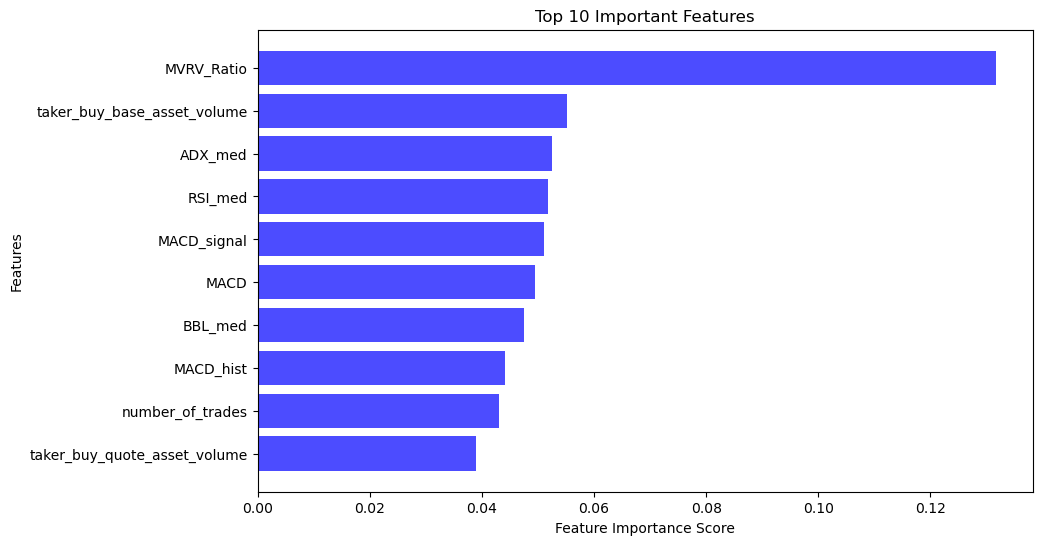

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46973 (\N{HANGUL SYLLABLE RAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54945 (\N{HANGUL SYLLABLE HOENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\s

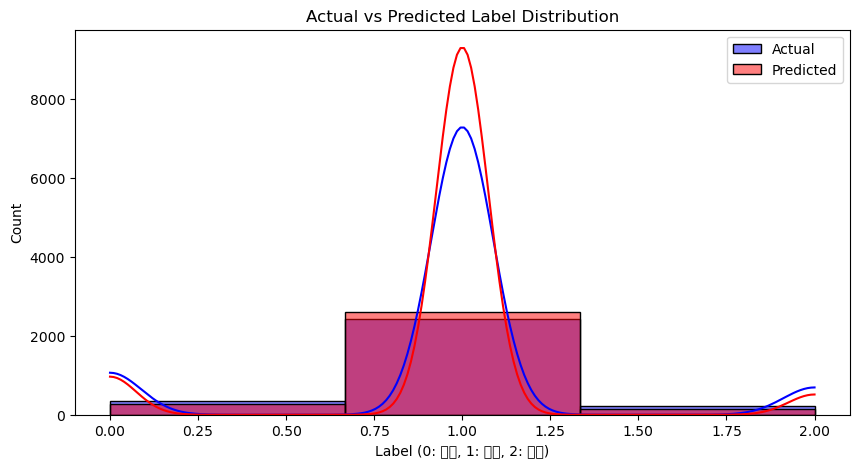

In [147]:
# 예측 결과 시각화 실행
analysis_15.plot_feature_importance()  # 실제 vs 예측된 값의 분포 비교
analysis_15.plot_prediction_distribution()

In [148]:
analysis_15.save_model(file_name="crypto_model_15.pkl")

✅ 모델이 crypto_model_15.pkl에 저장되었습니다.


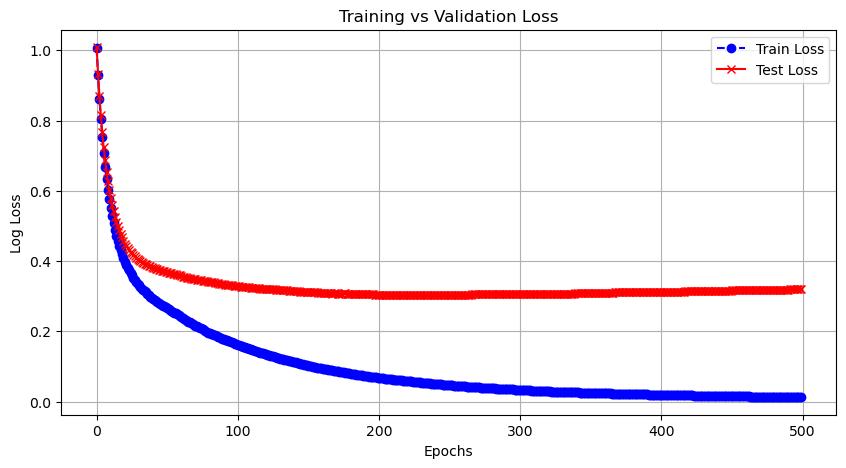

In [149]:
analysis_15.plot_loss()